### Análise de Redes Complexas

Nesta fase do projeto analisaremos as redes geradas a partir das bases BOVESPA e NYSE/NASDAQ e medidas de grafos dos seguintes meses estrategicamente selecionados:

* Março/2019
* Novembro/2019
* Março/2020
* Dezembro/2021
* Setembro/2022

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx import minimum_spanning_tree 
from pandas_datareader import data as pdr
from datetime import date
import statistics
import math
import scipy
import warnings
warnings.filterwarnings('ignore')

### BOVESPA

In [219]:
#importando a base de dados construída
df_b = pd.read_csv('df_b.csv')

#configurando a variável data para datetime e índice do df
df_b['data'] = pd.to_datetime(df_b['data']) 
df_b['data'] = df_b['data'].dt.strftime('%Y-%m-%d')
df_b = df_b.set_index('data')

In [220]:
#montando sub-bases para cada mes em estudo 

df_b_mar2019 = df_b.loc[(df_b.index >= '2019-03-01')
                     & (df_b.index <= '2019-03-31')]

df_b_nov2019 = df_b.loc[(df_b.index >= '2019-11-01')
                     & (df_b.index <= '2019-11-31')]

df_b_mar2020 = df_b.loc[(df_b.index >= '2020-03-01')
                     & (df_b.index <= '2020-03-31')]

df_b_dez2021 = df_b.loc[(df_b.index >= '2021-12-01')
                     & (df_b.index <= '2021-12-31')]

df_b_set2022 = df_b.loc[(df_b.index >= '2022-09-01')
                     & (df_b.index <= '2022-09-31')]

### Março 2019

In [221]:
#cria a matriz de correlação
cor_matrix_mar2019 = df_b_mar2019.iloc[:,1:].corr()
#exibindo as 5 primeiras linhas do df
cor_matrix_mar2019.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,1.000000,0.439553,0.628064,0.700481,0.094766,0.479478,0.486105,0.666681,0.634930,0.345865,...,0.532014,0.493291,-0.070653,0.523511,0.386055,0.321754,0.462130,0.283754,0.310702,0.315770
AMER3.SA,0.439553,1.000000,0.472362,0.605351,0.327872,0.262117,0.488097,0.538050,0.607958,0.265070,...,0.323863,0.395145,0.029079,0.438559,0.714271,0.255251,0.701650,0.425019,0.554830,0.614800
AZUL4.SA,0.628064,0.472362,1.000000,0.818922,0.563705,0.604593,0.567379,0.692497,0.693051,0.628639,...,0.387579,0.704291,-0.016722,0.636045,0.669025,0.583026,0.608419,0.263573,0.492789,0.289319
B3SA3.SA,0.700481,0.605351,0.818922,1.000000,0.457650,0.680217,0.672962,0.775285,0.790454,0.480066,...,0.574811,0.803077,0.074557,0.724615,0.669192,0.404462,0.623004,0.583738,0.743625,0.584275
BPAN4.SA,0.094766,0.327872,0.563705,0.457650,1.000000,0.392256,0.312428,0.238815,0.394339,0.416650,...,0.215867,0.507733,0.142941,0.303946,0.436837,0.384499,0.238794,0.284124,0.416468,0.217742


Segundo Gautier et. al., ao trabalhar com análises de correlações entre ações monetárias, é necessário transformar a matriz de correlações numa matriz de distâncias, aplicando o seguinte cálculo aos coeficientes de correlação:

$$d_{ij} = \sqrt{2(1-\rho_{ij})} $$

In [222]:
#função transformadora
def distance(x):
    return (2*(1-x))**(1/2)

In [223]:
#aplicando a transformação da matriz de correlações para uma matriz de distâncias
dist_matrix_mar2019 = cor_matrix_mar2019.apply(distance)
dist_matrix_mar2019.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,0.000000,1.058723,0.862480,0.773975,1.345536,1.020316,1.013800,0.816479,0.854482,1.143797,...,0.967456,1.006686,1.463320,0.976206,1.108102,1.164685,1.037179,1.196868,1.174137,1.169812
AMER3.SA,1.058723,0.000000,1.027266,0.888425,1.159420,1.214811,1.011833,0.961198,0.885485,1.212378,...,1.162873,1.099868,1.393500,1.059661,0.755948,1.220450,0.772463,1.072363,0.943579,0.877725
AZUL4.SA,0.862480,1.027266,0.000000,0.601793,0.934126,0.889277,0.930184,0.784223,0.783516,0.861813,...,1.106726,0.769037,1.425989,0.853176,0.813603,0.913207,0.884965,1.213612,1.007185,1.192209
B3SA3.SA,0.773975,0.888425,0.601793,0.000000,1.041489,0.799729,0.808750,0.670395,0.647374,1.019739,...,0.922159,0.627572,1.360473,0.742139,0.813398,1.091364,0.868327,0.912428,0.716066,0.911838
BPAN4.SA,1.345536,1.159420,0.934126,1.041489,0.000000,1.102491,1.172665,1.233844,1.100601,1.080139,...,1.252304,0.992237,1.309243,1.179877,1.061285,1.109506,1.233861,1.196559,1.080307,1.250807


In [224]:
#extraindo os indices 
stocks_mar2019 = dist_matrix_mar2019.index.values

#mudando de dataframe para matriz, pois é mais facil transformar em rede com o networkx
dist_matrix_mar2019 = np.asmatrix(dist_matrix_mar2019)

In [225]:
#cria o grafo com a matriz transformada
G_mar2019 = nx.from_numpy_matrix(dist_matrix_mar2019)

#dando nome aos nós
G_mar2019 = nx.relabel_nodes(G_mar2019,lambda x: stocks_mar2019[x])

edges,weights = zip(*nx.get_edge_attributes(G_mar2019,'weight').items())

#arestas e seus pesos
#G_mar2019.edges(data=True)


A ideia inicial era seguir com esse grafo e melhorá-lo para análise, exibindo somente correlações altas em módulo. Não deu certo por n motivos e o custo computacional era muito alto para prosseguir dessa maneira.
Por isso, optamos por seguir o projeto utilizando o algoritmo de Minimum Spanning Tree (ou Árvore de Expansão Mínima, MST), sugerido pelo próprio professor.

A MST é basicamente um grafo que liga todos os vértices existentes usando o mínimo de arestas, com custo compitacional baixo. Para este caso, utilizamos na MST o algoritmo padrão da biblioteca Networkx, o método de Kruskal.

Nesse algoritmo, analisamos as arestas por ordem de peso e aceitamos aquelas que não causam ciclos. Cada vértice é tratado como uma árvore e aceitar uma aresta significa unir duas árvores. Ao fim do processo temos uma única árvore de expansão mínima.

In [170]:
#criando a MST
T_mar2019 = minimum_spanning_tree(G_mar2019, ignore_nan=True)

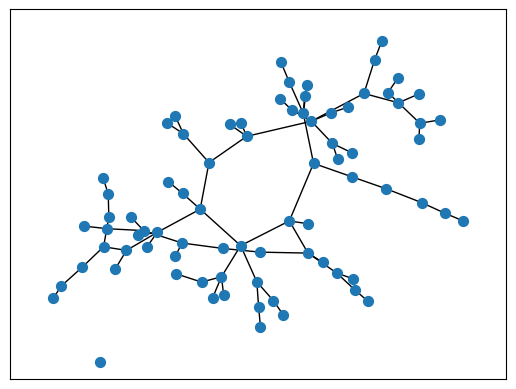

In [176]:
#exibindo a MST
plt.figure()
nx.draw_networkx(T_mar2019, with_labels=False, node_size = 50)
plt.show()

In [226]:
#gerando as medidas da rede
#grau
vk = dict(G_mar2019.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_mar2019)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_mar2019, weight='weights')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_mar2019, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_mar2019, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_mar2019, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  78.0253164556962
A eficiência da rede é:  1.0
A assortatividade da rede é:  -0.00016228498368640407
A proximidade da rede é dada por:  1.0
A intermedialidade da rede é:  0.0
O coeficiente de clustering da rede é  1.0


As métricas obtidas são totalmente viesadas, dado que temos um grafo no qual todos os nós se conectam. Dessa forma, refaçamos o cálculo das métricas levando em consideração apenas 25% das arestas que possuírem maior peso. 

In [276]:
#queremos saber qual é o terceiro quartil da lista de pesos para setar o threshold nesse valor
weight = pd.DataFrame(weights)
weight.describe()

,0
count,3003.000000
mean,1.034603
std,0.226131
min,0.283813
25%,0.882266
50%,1.023761
75%,1.171881
max,1.735962


In [277]:
#removendo 75% das arestas de menor peso 
to_remove = [(a,b) for a, b, attrs in G_mar2019.edges(data=True) if attrs["weight"] < 1.171881]
G_mar2019.remove_edges_from(to_remove)

In [278]:
#gerando as medidas da rede atualizada
#grau
vk = dict(G_mar2019.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_mar2019)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_mar2019, weight='weights')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_mar2019, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_mar2019, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_mar2019, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  21.0126582278481
A eficiência da rede é:  0.6345342421291789
A assortatividade da rede é:  -0.5042794141172168
A proximidade da rede é dada por:  0.5908294894411859
A intermedialidade da rede é:  0.009492617087553794
O coeficiente de clustering da rede é  0.654092020335688


### Novembro 2019

In [287]:
#craetes a correlation matrix
cor_matrix_nov2019 = df_b_nov2019.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix_nov2019.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,1.000000,0.263602,0.623357,0.453742,0.422528,0.326319,0.241225,0.693512,0.559859,0.102449,...,0.090532,0.067365,-0.100614,0.418619,0.450824,0.276026,0.146908,-0.085755,0.132685,-0.133896
AMER3.SA,0.263602,1.000000,0.321266,0.462612,0.495541,0.624133,0.183314,0.562690,0.656064,-0.038197,...,0.392079,0.102405,0.172700,0.128643,-0.069583,-0.186063,0.488730,0.193290,0.297563,0.388504
AZUL4.SA,0.623357,0.321266,1.000000,0.576049,0.561538,0.429144,0.509540,0.600599,0.499957,0.158362,...,0.249289,0.218995,0.003081,0.578841,0.380057,0.366465,0.633945,0.128579,0.210693,0.245565
B3SA3.SA,0.453742,0.462612,0.576049,1.000000,0.617829,0.510164,0.321247,0.618027,0.459087,-0.151602,...,0.329584,0.085564,0.019258,0.457383,0.170434,-0.142202,0.431232,0.094369,0.477185,0.428789
BPAN4.SA,0.422528,0.495541,0.561538,0.617829,1.000000,0.253793,0.415507,0.428131,0.384195,0.064167,...,0.554833,0.295291,0.196275,0.249441,0.148664,0.072424,0.698710,0.330948,0.224103,0.488568


In [288]:
#aplicando a transformação de distancia na matriz de correlações
dist_matrix_nov2019 = cor_matrix_nov2019.apply(distance)
dist_matrix_nov2019.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,0.000000,1.213588,0.867920,1.045235,1.074683,1.160759,1.231889,0.782928,0.938233,1.339814,...,1.348679,1.365749,1.483653,1.078314,1.048023,1.203307,1.306210,1.473605,1.317053,1.505919
AMER3.SA,1.213588,0.000000,1.165104,1.036714,1.004449,0.867026,1.278035,0.935212,0.829380,1.440970,...,1.102652,1.339847,1.286313,1.320119,1.462589,1.540171,1.011207,1.270204,1.185274,1.105890
AZUL4.SA,0.867920,1.165104,0.000000,0.920816,0.936442,1.068510,0.990414,0.893757,1.000043,1.297411,...,1.225325,1.249804,1.412033,0.917778,1.113502,1.125642,0.855635,1.320167,1.256429,1.228361
B3SA3.SA,1.045235,1.036714,0.920816,0.000000,0.874267,0.989784,1.165120,0.874040,1.040109,1.517631,...,1.157943,1.352358,1.400530,1.041746,1.288073,1.511425,1.066553,1.345831,1.022561,1.068842
BPAN4.SA,1.074683,1.004449,0.936442,0.874267,0.000000,1.221644,1.081197,1.069457,1.109779,1.368088,...,0.943575,1.187189,1.267853,1.225202,1.304865,1.362040,0.776260,1.156765,1.245711,1.011368


In [289]:
#extracts the indices from the correlation matrix, which are the stocks
stocks_nov2019 = dist_matrix_nov2019.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
dist_matrix_nov2019 = np.asmatrix(dist_matrix_nov2019)

In [290]:
#Crates graph using the data of the correlation matrix
G_nov2019 = nx.from_numpy_matrix(dist_matrix_nov2019)

#relabels the nodes to match the  stocks names
G_nov2019 = nx.relabel_nodes(G_nov2019,lambda x: stocks_nov2019[x])

edges,weights = zip(*nx.get_edge_attributes(G_nov2019,'weight').items())

#shows the edges with their corresponding weights
#G_nov2019.edges(data=True)

In [62]:
T_nov2019 = minimum_spanning_tree(G_nov2019)

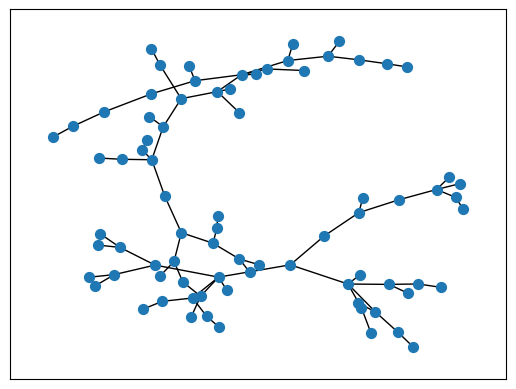

In [63]:
plt.figure()
nx.draw_networkx(T_nov2019, with_labels=False, node_size = 50)
plt.show()

In [291]:
#gerando as medidas da rede
#grau
vk = dict(G_nov2019.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_nov2019)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_nov2019, weight='weight')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_nov2019, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_nov2019, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_nov2019, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  78.0
A eficiência da rede é:  1.0
A assortatividade da rede é:  -0.012820512820319502
A proximidade da rede é dada por:  1.0
A intermedialidade da rede é:  0.0
O coeficiente de clustering da rede é  1.0


In [292]:
weight = pd.DataFrame(weights)
weight.describe()

,0
count,3081.000000
mean,1.225150
std,0.209593
min,0.195736
25%,1.080849
50%,1.237389
75%,1.372661
max,1.813623


In [294]:
to_remove = [(a,b) for a, b, attrs in G_nov2019.edges(data=True) if attrs["weight"] < 1.372661]
G_nov2019.remove_edges_from(to_remove)

In [297]:
#gerando as medidas da rede
#grau
vk = dict(G_nov2019.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_nov2019)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_nov2019, weight='weights')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_nov2019, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_nov2019, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_nov2019, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  19.49367088607595
A eficiência da rede é:  0.623282484041978
A assortatividade da rede é:  -0.45192249522806
A proximidade da rede é dada por:  0.5728178161831156
A intermedialidade da rede é:  0.00987198455552886
O coeficiente de clustering da rede é  0.29221200625667226


### Março 2020

In [298]:
#craetes a correlation matrix
cor_matrix_mar2020 = df_b_mar2020.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix_mar2020.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,1.000000,0.572554,0.794314,0.646572,0.788753,0.573955,0.680051,0.731813,0.731917,0.556037,...,0.545707,0.822861,0.611594,0.815571,0.620344,0.598416,0.597274,0.730756,0.737945,0.663290
AMER3.SA,0.572554,1.000000,0.659807,0.882576,0.840426,0.779003,0.570252,0.876733,0.850600,0.827821,...,0.560182,0.606789,0.784487,0.806096,0.737926,0.879419,0.726449,0.781992,0.580232,0.477048
AZUL4.SA,0.794314,0.659807,1.000000,0.821649,0.746042,0.502181,0.821420,0.754565,0.770968,0.660245,...,0.443277,0.608359,0.818636,0.818819,0.756519,0.697565,0.845258,0.851169,0.867420,0.690426
B3SA3.SA,0.646572,0.882576,0.821649,1.000000,0.795534,0.792082,0.744357,0.922964,0.900555,0.844800,...,0.629272,0.639498,0.801755,0.878667,0.783132,0.886867,0.822084,0.899290,0.710419,0.663505
BPAN4.SA,0.788753,0.840426,0.746042,0.795534,1.000000,0.715564,0.515263,0.836494,0.794386,0.755879,...,0.491336,0.672849,0.724589,0.819976,0.739056,0.803622,0.660499,0.774747,0.619348,0.471001


In [299]:
dist_matrix_mar2020 = cor_matrix_mar2020.apply(distance)
dist_matrix_mar2020.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,0.000000,0.924604,0.641383,0.840748,0.649995,0.923087,0.799936,0.732375,0.732234,0.942299,...,0.953198,0.595213,0.881369,0.607337,0.871385,0.896196,0.897470,0.733817,0.723955,0.820622
AMER3.SA,0.924604,0.000000,0.824856,0.484611,0.564932,0.664826,0.927090,0.496522,0.546626,0.586820,...,0.937890,0.886805,0.656526,0.622742,0.723981,0.491082,0.739664,0.660316,0.916262,1.022694
AZUL4.SA,0.641383,0.824856,0.000000,0.597246,0.712682,0.997817,0.597628,0.700621,0.676804,0.824324,...,1.055199,0.885033,0.602269,0.601965,0.697827,0.777734,0.556314,0.545584,0.514936,0.786860
B3SA3.SA,0.840748,0.484611,0.597246,0.000000,0.639478,0.644854,0.715043,0.392519,0.445972,0.557135,...,0.861079,0.849120,0.629674,0.492611,0.658586,0.475674,0.596517,0.448798,0.761027,0.820360
BPAN4.SA,0.649995,0.564932,0.712682,0.639478,0.000000,0.754235,0.984618,0.571850,0.641271,0.698743,...,1.008627,0.808889,0.742173,0.600041,0.722418,0.626702,0.824016,0.671198,0.872527,1.028590


In [300]:
#extracts the indices from the correlation matrix, which are the stocks
stocks_mar2020 = dist_matrix_mar2020.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
dist_matrix_mar2020 = np.asmatrix(dist_matrix_mar2020)

In [301]:
#Crates graph using the data of the correlation matrix
G_mar2020 = nx.from_numpy_matrix(dist_matrix_mar2020)

#relabels the nodes to match the  stocks names
G_mar2020 = nx.relabel_nodes(G_mar2020,lambda x: stocks_mar2020[x])

edges,weights = zip(*nx.get_edge_attributes(G_mar2020,'weight').items())

#shows the edges with their corresponding weights
#G_mar2020.edges(data=True)

In [191]:
T_mar2020 = minimum_spanning_tree(G_mar2020)

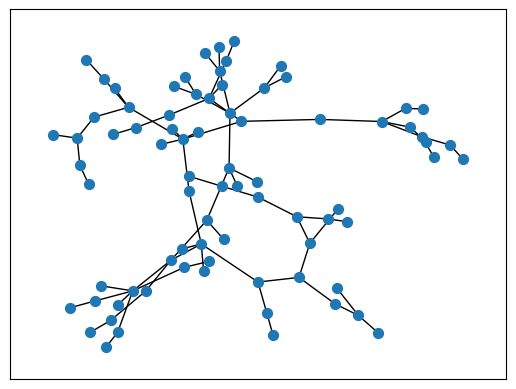

In [192]:
plt.figure()
nx.draw_networkx(T_mar2020, with_labels=False, node_size = 50)
plt.show()

In [303]:
#gerando as medidas da rede
#grau
vk = dict(G_mar2020.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_mar2020)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_mar2020, weight='weight')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_mar2020, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_mar2020, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_mar2020, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  78.0
A eficiência da rede é:  1.0
A assortatividade da rede é:  -0.012820512820460258
A proximidade da rede é dada por:  1.0
A intermedialidade da rede é:  0.0
O coeficiente de clustering da rede é  1.0


In [304]:
weight = pd.DataFrame(weights)
weight.describe()

,0
count,3081.000000
mean,0.699007
std,0.172237
min,0.114423
25%,0.577293
50%,0.680082
75%,0.813130
max,1.325054


In [306]:
to_remove = [(a,b) for a, b, attrs in G_mar2020.edges(data=True) if attrs["weight"] < 0.813130]
G_mar2020.remove_edges_from(to_remove)

In [307]:
#gerando as medidas da rede
#grau
vk = dict(G_mar2020.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_mar2020)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_mar2020, weight='weights')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_mar2020, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_mar2020, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_mar2020, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  19.49367088607595
A eficiência da rede é:  0.6249594287568971
A assortatividade da rede é:  -0.5761947088465388
A proximidade da rede é dada por:  0.5839926767972696
A intermedialidade da rede é:  0.00974131353878189
O coeficiente de clustering da rede é  0.6634260905218791


### Dezembro 2021

In [308]:
#craetes a correlation matrix
cor_matrix_dez2021 = df_b_dez2021.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix_dez2021.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,1.000000,0.231771,0.312335,0.550058,0.140105,0.410597,0.571073,0.512303,0.512858,-0.055743,...,0.239711,0.187495,0.225342,0.711926,0.647671,0.332128,0.215420,0.511130,0.141919,0.225887
AMER3.SA,0.231771,1.000000,0.317659,0.309537,0.327630,0.465623,0.273607,0.297493,0.305738,-0.339608,...,0.223651,0.381717,0.341765,0.397444,0.249442,0.227000,0.571290,0.464330,0.011051,0.197964
AZUL4.SA,0.312335,0.317659,1.000000,0.142759,0.145115,0.467985,0.381711,0.136591,0.170215,-0.507443,...,-0.181519,-0.181170,0.461202,0.394765,0.415452,0.287175,0.226609,0.393424,0.316624,0.147256
B3SA3.SA,0.550058,0.309537,0.142759,1.000000,0.567987,0.372224,0.612857,0.504208,0.456001,-0.165910,...,0.440375,0.393236,0.441438,0.535579,0.419893,0.168367,0.361175,0.582132,0.107776,0.335333
BPAN4.SA,0.140105,0.327630,0.145115,0.567987,1.000000,0.391965,0.342447,0.113201,0.075204,-0.019768,...,0.357165,0.472113,0.643168,0.301433,0.143622,-0.092993,0.558639,0.472301,0.122576,0.409800


In [309]:
dist_matrix_dez2021 = cor_matrix_dez2021.apply(distance)
dist_matrix_dez2021.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,0.000000,1.239539,1.172744,0.948622,1.311407,1.085729,0.926204,0.987620,0.987059,1.453095,...,1.233117,1.274759,1.244715,0.759045,0.839439,1.155744,1.252662,0.988807,1.310023,1.244277
AMER3.SA,1.239539,0.000000,1.168196,1.175128,1.159630,1.033806,1.205315,1.185333,1.178357,1.636831,...,1.246073,1.112010,1.147375,1.097776,1.225200,1.243383,0.925970,1.035055,1.406378,1.266519
AZUL4.SA,1.172744,1.168196,0.000000,1.309382,1.307582,1.031518,1.112015,1.314084,1.288243,1.736343,...,1.537218,1.536991,1.038073,1.100214,1.081248,1.194005,1.243697,1.101432,1.169082,1.305943
B3SA3.SA,0.948622,1.175128,1.309382,0.000000,0.929530,1.120514,0.879935,0.995783,1.043071,1.527029,...,1.057946,1.101603,1.056940,0.963764,1.077133,1.289677,1.130332,0.914186,1.335833,1.152967
BPAN4.SA,1.311407,1.159630,1.307582,0.929530,0.000000,1.102755,1.146781,1.331765,1.359997,1.428123,...,1.133873,1.027509,0.844786,1.182004,1.308723,1.478508,0.939533,1.027326,1.324707,1.086462


In [310]:
#extracts the indices from the correlation matrix, which are the stocks
stocks_dez2021 = dist_matrix_dez2021.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
dist_matrix_dez2021 = np.asmatrix(dist_matrix_dez2021)

In [311]:
#Crates graph using the data of the correlation matrix
G_dez2021 = nx.from_numpy_matrix(dist_matrix_dez2021)

#relabels the nodes to match the  stocks names
G_dez2021 = nx.relabel_nodes(G_dez2021,lambda x: stocks_dez2021[x])

edges,weights = zip(*nx.get_edge_attributes(G_dez2021,'weight').items())

#shows the edges with their corresponding weights
#G_dez2021.edges(data=True)

In [56]:
T_dez2021 = minimum_spanning_tree(G_dez2021)

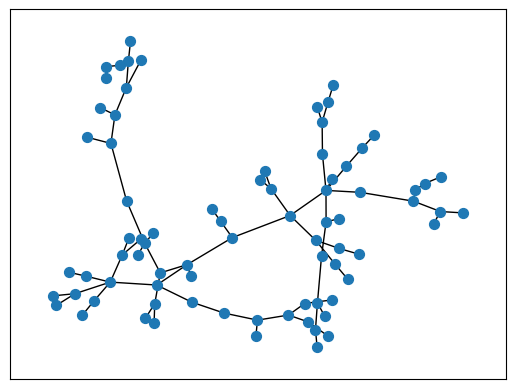

In [199]:
plt.figure()
nx.draw_networkx(T_dez2021, with_labels=False, node_size = 50)
plt.show()

In [312]:
#gerando as medidas da rede
#grau
vk = dict(G_dez2021.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_dez2021)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_dez2021, weight='weight')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_dez2021, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_dez2021, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_dez2021, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  78.0
A eficiência da rede é:  1.0
A assortatividade da rede é:  -0.012820512820388435
A proximidade da rede é dada por:  1.0
A intermedialidade da rede é:  0.0
O coeficiente de clustering da rede é  1.0


In [313]:
weight = pd.DataFrame(weights)
weight.describe()

,0
count,3081.000000
mean,1.152827
std,0.215508
min,0.189956
25%,1.012445
50%,1.161333
75%,1.304562
max,1.811259


In [314]:
to_remove = [(a,b) for a, b, attrs in G_dez2021.edges(data=True) if attrs["weight"] < 1.304562]
G_dez2021.remove_edges_from(to_remove)

In [315]:
#gerando as medidas da rede
#grau
vk = dict(G_dez2021.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_dez2021)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_dez2021, weight='weights')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_dez2021, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_dez2021, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_dez2021, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  19.518987341772153
A eficiência da rede é:  0.6250676187385049
A assortatividade da rede é:  -0.48010728443633827
A proximidade da rede é dada por:  0.5795213748543906
A intermedialidade da rede é:  0.009741313538781892
O coeficiente de clustering da rede é  0.49418794396615634


### Setembro 2022

In [316]:
#craetes a correlation matrix
cor_matrix_set2022 = df_b_set2022.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix_set2022.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,1.000000,0.229587,0.548242,0.469374,0.492184,0.015639,0.350817,0.662589,0.693846,0.448428,...,0.455856,0.355219,0.303270,0.557002,0.561326,0.415362,0.194870,0.411665,0.268941,0.562843
AMER3.SA,0.229587,1.000000,0.684855,0.380280,0.102350,0.223577,0.461792,0.166917,0.156069,0.540403,...,0.191068,0.133553,0.436171,0.333233,0.551949,0.578958,0.876619,0.490271,0.216564,0.465131
AZUL4.SA,0.548242,0.684855,1.000000,0.575457,0.484078,0.180998,0.563881,0.386573,0.389498,0.663308,...,0.379295,0.332542,0.591144,0.567389,0.633641,0.661897,0.667621,0.481083,0.165410,0.530101
B3SA3.SA,0.469374,0.380280,0.575457,1.000000,0.552360,0.097601,0.587293,0.644724,0.628776,0.362746,...,0.446206,0.334871,0.500376,0.573416,0.696871,0.281734,0.470778,0.624615,0.551092,0.643465
BPAN4.SA,0.492184,0.102350,0.484078,0.552360,1.000000,0.000569,0.670984,0.385590,0.442233,0.441070,...,0.482031,0.440343,0.534580,0.594113,0.656197,0.376078,0.244742,0.330843,0.433764,0.271253


In [317]:
dist_matrix_set2022 = cor_matrix_set2022.apply(distance)
dist_matrix_set2022.head()

,ABEV3.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BPAN4.SA,BBSE3.SA,BRML3.SA,BBDC3.SA,BBDC4.SA,BRAP4.SA,...,VIVT3.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIIA3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,0.000000,1.241300,0.950534,1.030171,1.007786,1.403111,1.139459,0.821476,0.782501,1.050307,...,1.043211,1.135589,1.180449,0.941274,0.936668,1.081331,1.268960,1.084744,1.209180,0.935048
AMER3.SA,1.241300,0.000000,0.793908,1.113301,1.339888,1.246132,1.037504,1.290800,1.299177,0.958747,...,1.271953,1.316394,1.061912,1.154787,0.946626,0.917652,0.496752,1.009682,1.251748,1.034282
AZUL4.SA,0.950534,0.793908,0.000000,0.921459,1.015797,1.279846,0.933937,1.107634,1.104991,0.820599,...,1.114186,1.155386,0.904274,0.930173,0.855989,0.822317,0.815327,1.018741,1.291968,0.969431
B3SA3.SA,1.030171,1.113301,0.921459,0.000000,0.946193,1.343428,0.908523,0.842942,0.861654,1.128941,...,1.052420,1.153368,0.999624,0.923671,0.778626,1.198554,1.028807,0.866469,0.947531,0.844435
BPAN4.SA,1.007786,1.339888,1.015797,0.946193,0.000000,1.413811,0.811191,1.108522,1.056189,1.057289,...,1.017811,1.057977,0.964801,0.900984,0.829220,1.117069,1.229030,1.156855,1.064176,1.207267


In [318]:
#extracts the indices from the correlation matrix, which are the stocks
stocks_set2022 = dist_matrix_set2022.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
dist_matrix_set2022 = np.asmatrix(dist_matrix_set2022)

In [319]:
#Crates graph using the data of the correlation matrix
G_set2022 = nx.from_numpy_matrix(dist_matrix_set2022)

#relabels the nodes to match the  stocks names
G_set2022 = nx.relabel_nodes(G_set2022,lambda x: stocks_set2022[x])

edges,weights = zip(*nx.get_edge_attributes(G_set2022,'weight').items())

#shows the edges with their corresponding weights
#G_set2022.edges(data=True)

In [205]:
T_set2022 = minimum_spanning_tree(G_set2022)

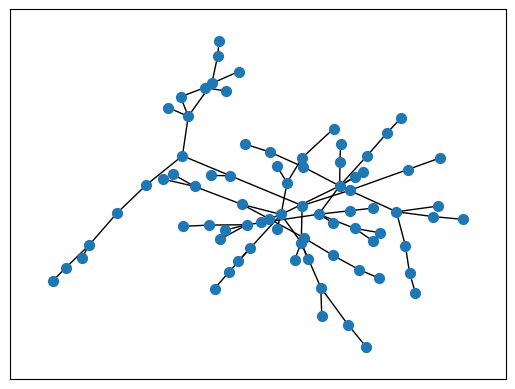

In [206]:
plt.figure()
nx.draw_networkx(T_set2022, with_labels=False, node_size = 50)
plt.show()

In [320]:
#gerando as medidas da rede
#grau
vk = dict(G_set2022.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_set2022)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_set2022, weight='weight')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_set2022, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_set2022, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_set2022, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  78.0
A eficiência da rede é:  1.0
A assortatividade da rede é:  -0.012820512820397903
A proximidade da rede é dada por:  1.0
A intermedialidade da rede é:  0.0
O coeficiente de clustering da rede é  1.0


In [321]:
weight = pd.DataFrame(weights)
weight.describe()

,0
count,3081.000000
mean,1.090136
std,0.208279
min,0.203515
25%,0.950534
50%,1.092517
75%,1.222956
max,1.768396


In [322]:
to_remove = [(a,b) for a, b, attrs in G_set2022.edges(data=True) if attrs["weight"] < 1.222956]
G_set2022.remove_edges_from(to_remove)

In [323]:
#gerando as medidas da rede
#grau
vk = dict(G_set2022.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_set2022)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_set2022, weight='weight')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_set2022, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_set2022, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_set2022, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  19.49367088607595
A eficiência da rede é:  0.6249594287568971
A assortatividade da rede é:  -0.4491213423584381
A proximidade da rede é dada por:  0.5795655075129528
A intermedialidade da rede é:  0.009741313538781896
O coeficiente de clustering da rede é  0.4945871726405008


* A análise das redes da NASDAQ/NYSE foram deixadas de lado pelo alto custo computacional envolvendo a criação dos grafos e os cálculos das métricas. 

### NASDAQ/NYSE

In [210]:
#importando a base de dados construída
df_ny = pd.read_csv('df_ny.csv')

#configurando a variável data para datetime e índice do df
df_ny['data'] = pd.to_datetime(df_ny['data'])
df_ny['data'] = df_ny['data'].dt.strftime('%Y-%m-%d')
df_ny = df_ny.set_index('data')

In [211]:
df_ny_mar2019 = df_ny.loc[(df_ny.index >= '2019-03-01')
                     & (df_ny.index <= '2019-03-31')]

df_ny_nov2019 = df_ny.loc[(df_ny.index >= '2019-11-01')
                     & (df_ny.index <= '2019-11-31')]

df_ny_mar2020 = df_ny.loc[(df_ny.index >= '2020-03-01')
                     & (df_ny.index <= '2020-03-31')]

df_ny_dez2021 = df_ny.loc[(df_ny.index >= '2021-12-01')
                     & (df_ny.index <= '2021-12-31')]

df_ny_set2022 = df_ny.loc[(df_ny.index >= '2022-09-01')
                     & (df_ny.index <= '2022-09-31')]

### Março 2019

In [213]:
#craetes a correlation matrix
cor_matrix_mar2019 = df_ny_mar2019.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix_mar2019.head()

,MMM,EGHT,AOS,ATEN,AIR,ABB,ABT,ABBV,ANF,AGD,...,ZG,ZION,ZIONL,ZIONO,ZIONP,ZKIN,ZS,ZUMZ,ZYNE,ZYXI
MMM,1.000000,0.679533,0.509539,0.625697,0.365591,0.593468,0.701405,0.523735,0.144051,0.648869,...,0.431255,0.567798,0.048585,-0.021090,0.123247,-0.018142,0.374362,-0.003114,0.208273,-0.232129
EGHT,0.679533,1.000000,0.382054,0.671961,0.595174,0.620913,0.391394,0.360035,0.098696,0.559940,...,0.623069,0.466135,0.112933,0.263313,-0.196716,-0.390481,0.326178,0.121335,0.157597,-0.199040
AOS,0.509539,0.382054,1.000000,0.532213,0.579414,0.617358,0.513171,0.325403,0.131408,0.700327,...,0.339512,0.475679,0.210861,0.190976,-0.047667,0.050036,0.343335,0.361531,0.150360,-0.118645
ATEN,0.625697,0.671961,0.532213,1.000000,0.405407,0.565371,0.578967,0.532531,0.231906,0.532689,...,0.495758,0.343551,0.133763,0.119164,-0.234082,-0.414681,0.383229,0.347183,0.126421,-0.375589
AIR,0.365591,0.595174,0.579414,0.405407,1.000000,0.503694,0.292020,0.412871,-0.003384,0.637489,...,0.485046,0.633508,0.073590,0.363075,0.046681,-0.253472,0.313678,0.362478,-0.139299,-0.103016


In [214]:
#aplicando a transformação da matriz de correlações para uma matriz de distâncias
dist_matrix_mar2019 = cor_matrix_mar2019.apply(distance)
dist_matrix_mar2019.head()

,MMM,EGHT,AOS,ATEN,AIR,ABB,ABT,ABBV,ANF,AGD,...,ZG,ZION,ZIONL,ZIONO,ZIONP,ZKIN,ZS,ZUMZ,ZYNE,ZYXI
MMM,0.000000,0.800584,0.990415,0.865220,1.126418,0.901701,0.772781,0.975977,1.308395,0.838010,...,1.066532,0.929733,1.379431,1.429049,1.324200,1.426984,1.118605,1.416414,1.258354,1.569796
EGHT,0.800584,0.000000,1.111707,0.809986,0.899806,0.870732,1.103274,1.131340,1.342612,0.938147,...,0.868253,1.033311,1.331966,1.213826,1.547072,1.667622,1.160881,1.325643,1.298001,1.548573
AOS,0.990415,1.111707,0.000000,0.967251,0.917154,0.874806,0.986741,1.161548,1.318023,0.774175,...,1.149337,1.024033,1.256295,1.272025,1.447527,1.378379,1.146006,1.130017,1.303565,1.495757
ATEN,0.865220,0.809986,0.967251,0.000000,1.090498,0.932340,0.917642,0.966922,1.239431,0.966759,...,1.004233,1.145817,1.316235,1.327280,1.571039,1.682071,1.110649,1.142644,1.321801,1.658667
AIR,1.126418,0.899806,0.917154,1.090498,0.000000,0.996299,1.189941,1.083632,1.416604,0.851483,...,1.014843,0.856145,1.361183,1.128650,1.380811,1.583333,1.171599,1.129178,1.509502,1.485271


In [215]:
#extracts the indices from the correlation matrix, which are the stocks
stocks_mar2019 = dist_matrix_mar2019.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
dist_matrix_mar2019 = np.asmatrix(dist_matrix_mar2019)

In [216]:
#Crates graph using the data of the correlation matrix
G_mar2019 = nx.from_numpy_matrix(dist_matrix_mar2019)

#relabels the nodes to match the  stocks names
G_mar2019 = nx.relabel_nodes(G_mar2019,lambda x: stocks_mar2019[x])

edges,weights = zip(*nx.get_edge_attributes(G_mar2019,'weight').items())

#shows the edges with their corresponding weights
#G_mar2019.edges(data=True)


In [8]:
T_mar2019 = minimum_spanning_tree(G_mar2019, ignore_nan=True)

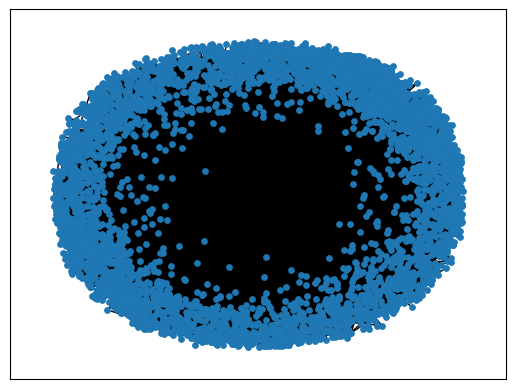

In [9]:
plt.figure()
nx.draw_networkx(T_mar2019, with_labels=False, node_size = 15)
plt.show()

In [217]:
#gerando as medidas da rede
#grau
vk = dict(G_mar2019.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_mar2019)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_mar2019, weight='weights')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_mar2019, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_mar2019, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_mar2019, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

O grau médio da rede é:  4754.999579478554
A eficiência da rede é:  0.9999999115622615



KeyboardInterrupt



### Novembro 2019

In [10]:
#craetes a correlation matrix
cor_matrix_nov2019 = df_ny_nov2019.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix_nov2019.head()

,MMM,EGHT,AOS,ATEN,AIR,ABB,ABT,ABBV,ANF,AGD,...,ZG,ZION,ZIONL,ZIONO,ZIONP,ZKIN,ZS,ZUMZ,ZYNE,ZYXI
MMM,1.000000,-0.019187,0.364437,0.027520,0.389187,0.693517,-0.075176,0.457193,0.661543,0.649846,...,-0.129757,0.654575,-0.084587,-0.327279,-0.163749,-0.136464,0.290899,0.423630,-0.301289,0.209477
EGHT,-0.019187,1.000000,0.166785,-0.149679,-0.194984,0.161858,0.208678,0.358422,-0.025402,0.339064,...,0.579282,-0.136575,-0.285081,0.143713,0.339586,0.066096,0.227801,-0.261452,-0.223623,0.328708
AOS,0.364437,0.166785,1.000000,0.121439,0.481202,0.392720,0.151941,0.173030,0.556923,0.269282,...,0.130832,0.403362,-0.118364,-0.112712,0.154923,-0.098755,0.195597,0.338787,-0.150993,0.263245
ATEN,0.027520,-0.149679,0.121439,1.000000,0.203371,0.140035,0.566993,0.153723,0.309932,0.088704,...,-0.289739,0.101914,0.218352,0.042502,-0.130067,-0.235405,0.209905,0.231931,0.345121,0.434035
AIR,0.389187,-0.194984,0.481202,0.203371,1.000000,0.150241,0.152839,-0.025867,0.496034,-0.009930,...,-0.370597,0.231680,0.336878,-0.314154,-0.330968,-0.471499,0.252544,0.559188,0.023489,0.184755


In [ ]:
dist_matrix_nov2019 = cor_matrix_nov2019.apply(distance)
dist_matrix_nov2019.head()

In [11]:
#extracts the indices from the correlation matrix, which are the stocks
stocks_nov2019 = dist_matrix_nov2019.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
dist_matrix_nov2019 = np.asmatrix(dist_matrix_nov2019)

In [12]:
#Crates graph using the data of the correlation matrix
G_nov2019 = nx.from_numpy_matrix(dist_matrix_nov2019)

#relabels the nodes to match the  stocks names
G_nov2019 = nx.relabel_nodes(G_nov2019,lambda x: stocks_nov2019[x])

#shows the edges with their corresponding weights
#G_nov2019.edges(data=True)

In [13]:
T_nov2019 = minimum_spanning_tree(G_nov2019, ignore_nan=True)

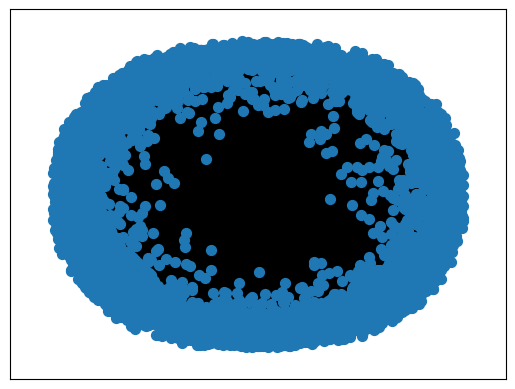

In [14]:
plt.figure()
nx.draw_networkx(T_nov2019, with_labels=False, node_size = 50)
plt.show()

In [ ]:
#gerando as medidas da rede
#grau
vk = dict(G_nov2019.degree(weight = 'weights')).values()
vk = np.array(list(vk))
md = np.mean(vk)
print("O grau médio da rede é: ", md)

#eficiencia
E = nx.global_efficiency(G_nov2019)
print("A eficiência da rede é: ", E)

#assortatividade
r = nx.degree_assortativity_coefficient(G_nov2019, weight='weight')
print("A assortatividade da rede é: ", r)

#proximidade
CLC = dict(nx.closeness_centrality(G_nov2019, distance='weights'))
CLC = list(CLC.values())
av_clc = np.mean(CLC)
print("A proximidade da rede é dada por: ", av_clc)

#intermedialidade
B = dict(nx.betweenness_centrality(G_nov2019, weight = 'weights'))
B = list(B.values())
av_B = np.mean(B)
print("A intermedialidade da rede é: ", av_B)

#clustering
Cl = nx.average_clustering(G_nov2019, weight = 'weights')
print("O coeficiente de clustering da rede é ", Cl)

### Março 2020

In [15]:
#craetes a correlation matrix
cor_matrix_mar2020 = df_ny_mar2020.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix_mar2020.head()

,MMM,EGHT,AOS,ATEN,AIR,ABB,ABT,ABBV,ANF,AGD,...,ZG,ZION,ZIONL,ZIONO,ZIONP,ZKIN,ZS,ZUMZ,ZYNE,ZYXI
MMM,1.000000,0.664157,0.738697,0.417828,0.342786,0.792504,0.897022,0.787904,0.603310,0.547551,...,0.469663,0.816762,-0.105991,0.493713,0.077472,0.182720,0.508285,0.563610,0.369882,0.560494
EGHT,0.664157,1.000000,0.444754,0.469548,0.366845,0.681853,0.455799,0.498693,0.649383,0.547399,...,0.594408,0.601262,0.280693,0.601600,0.113494,-0.147011,0.488299,0.712473,0.367591,0.453520
AOS,0.738697,0.444754,1.000000,0.310945,0.207271,0.532446,0.807740,0.687829,0.386701,0.480193,...,0.490707,0.699546,0.176972,0.084377,-0.017567,0.270138,0.416441,0.205813,0.303441,0.628742
ATEN,0.417828,0.469548,0.310945,1.000000,0.670670,0.530494,0.200383,0.484960,0.565220,0.477874,...,0.651637,0.507396,0.260823,0.448719,-0.044752,0.204996,0.453241,0.497682,0.746268,0.481895
AIR,0.342786,0.366845,0.207271,0.670670,1.000000,0.622775,0.226035,0.505765,0.654463,0.764858,...,0.731163,0.405812,0.083083,0.575541,0.516807,0.312591,0.196110,0.472500,0.609350,0.481728


In [16]:
#extracts the indices from the correlation matrix, which are the stocks
stocks_mar2020 = cor_matrix_mar2020.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
cor_matrix_mar2020 = np.asmatrix(cor_matrix_mar2020)

In [17]:
#Crates graph using the data of the correlation matrix
G_mar2020 = nx.from_numpy_matrix(cor_matrix_mar2020)

#relabels the nodes to match the  stocks names
G_mar2020 = nx.relabel_nodes(G_mar2020,lambda x: stocks_mar2020[x])

#shows the edges with their corresponding weights
#G_mar2020.edges(data=True)

In [18]:
T_mar2020 = minimum_spanning_tree(G_mar2020, ignore_nan=True)

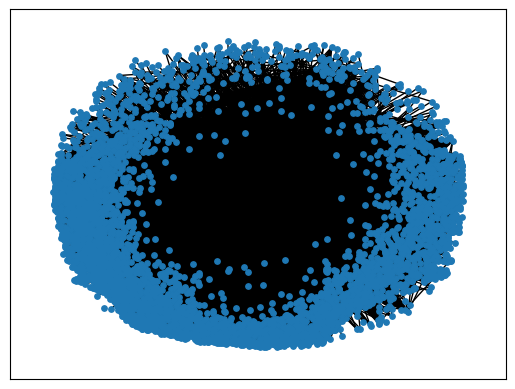

In [19]:
plt.figure()
nx.draw_networkx(T_mar2020, with_labels=False, node_size = 15)
plt.show()

### Dezembro 2021

In [20]:
#craetes a correlation matrix
cor_matrix_dez2021 = df_ny_dez2021.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix_dez2021.head()

,MMM,EGHT,AOS,ATEN,AIR,ABB,ABT,ABBV,ANF,AGD,...,ZG,ZION,ZIONL,ZIONO,ZIONP,ZKIN,ZS,ZUMZ,ZYNE,ZYXI
MMM,1.000000,0.033526,0.540999,0.012615,0.040499,0.521051,0.265549,0.544384,0.186663,0.262583,...,0.037549,0.538909,0.089269,0.244361,0.099595,-0.208443,-0.507280,0.349791,-0.252590,0.175960
EGHT,0.033526,1.000000,0.041229,0.336678,0.571404,0.325954,0.195264,-0.139104,0.592412,0.567231,...,0.305398,0.305868,0.324708,-0.018568,0.120872,0.645485,0.326000,0.482614,0.593319,0.296068
AOS,0.540999,0.041229,1.000000,0.541560,0.402148,0.716855,0.487088,0.340599,0.194372,0.593710,...,0.095878,0.572566,0.024952,0.160817,0.246259,0.278146,0.244083,0.421437,0.019093,0.121948
ATEN,0.012615,0.336678,0.541560,1.000000,0.627347,0.355492,0.269549,0.072649,0.548786,0.535773,...,0.238385,0.358772,0.268613,-0.264461,0.046636,0.651849,0.658631,0.562159,0.354626,0.312459
AIR,0.040499,0.571404,0.402148,0.627347,1.000000,0.523681,0.313068,-0.139676,0.699404,0.611985,...,0.407139,0.568569,0.295521,-0.039525,-0.079624,0.727380,0.393909,0.692117,0.546316,0.396467


In [21]:
#extracts the indices from the correlation matrix, which are the stocks
stocks_dez2021 = cor_matrix_dez2021.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
cor_matrix_dez2021 = np.asmatrix(cor_matrix_dez2021)

In [22]:
#Crates graph using the data of the correlation matrix
G_dez2021 = nx.from_numpy_matrix(cor_matrix_dez2021)

#relabels the nodes to match the  stocks names
G_dez2021 = nx.relabel_nodes(G_dez2021,lambda x: stocks_dez2021[x])

#shows the edges with their corresponding weights
#G_dez2021.edges(data=True)

In [23]:
T_dez2021 = minimum_spanning_tree(G_dez2021, ignore_nan=True)

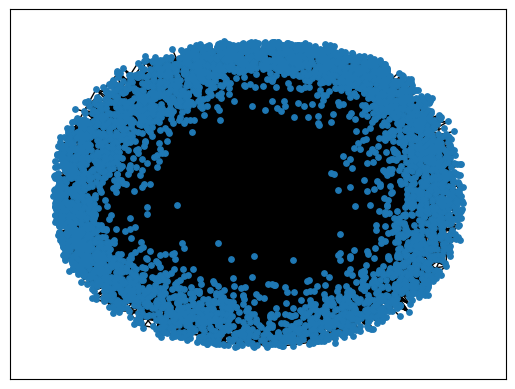

In [29]:
plt.figure()
nx.draw_networkx(T_dez2021, with_labels=False, node_size = 15)
plt.show()

### Setembro 2022

In [24]:
#craetes a correlation matrix
cor_matrix_set2022 = df_ny_set2022.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix_set2022.head()

,MMM,EGHT,AOS,ATEN,AIR,ABB,ABT,ABBV,ANF,AGD,...,ZG,ZION,ZIONL,ZIONO,ZIONP,ZKIN,ZS,ZUMZ,ZYNE,ZYXI
MMM,1.000000,0.056721,0.488205,0.375458,0.354859,0.492561,0.567058,0.392843,0.538265,0.589942,...,0.425520,0.353060,-0.300986,0.015317,0.443522,0.111673,0.442031,0.513174,0.197155,0.485601
EGHT,0.056721,1.000000,0.286413,0.390195,0.375469,0.611202,0.230554,0.145700,0.125320,0.021065,...,0.141707,0.257425,-0.063213,0.475666,-0.058403,0.224962,0.573424,0.567318,0.202613,0.165577
AOS,0.488205,0.286413,1.000000,0.170645,0.453439,0.705632,0.418568,0.402352,0.619082,0.481560,...,0.477859,0.592718,-0.087863,0.372543,-0.075932,0.269574,0.198317,0.575424,0.275628,0.423612
ATEN,0.375458,0.390195,0.170645,1.000000,0.426118,0.539776,0.145738,0.068730,0.224645,0.295357,...,0.108815,0.099918,-0.318263,0.197289,0.192875,0.334408,0.741404,0.390521,0.349380,0.298465
AIR,0.354859,0.375469,0.453439,0.426118,1.000000,0.754843,0.287989,0.025499,0.262671,0.544337,...,0.362434,0.450253,0.105896,0.481781,0.308057,0.551847,0.630389,0.448805,0.240204,0.379123


In [25]:
#extracts the indices from the correlation matrix, which are the stocks
stocks_set2022 = cor_matrix_set2022.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
cor_matrix_set2022 = np.asmatrix(cor_matrix_set2022)

In [26]:
#Crates graph using the data of the correlation matrix
G_set2022 = nx.from_numpy_matrix(cor_matrix_set2022)

#relabels the nodes to match the  stocks names
G_set2022 = nx.relabel_nodes(G_set2022,lambda x: stocks_set2022[x])

#shows the edges with their corresponding weights
#G_set2022.edges(data=True)

In [27]:
T_set2022 = minimum_spanning_tree(G_set2022, ignore_nan=True)

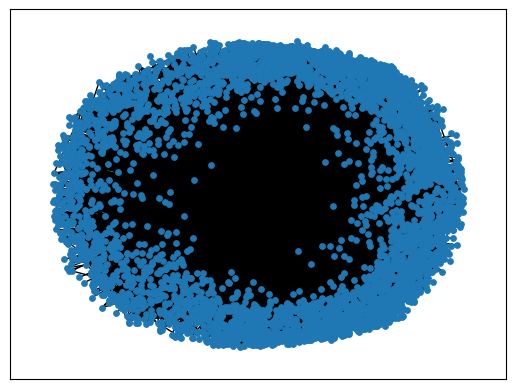

In [28]:
plt.figure()
nx.draw_networkx(T_set2022, with_labels=False, node_size = 15)
plt.show()

No caso da base NASDAQ/NYSE, tivemos vários problemas quanto ao custo computacional dos algoritmos. Ao fim das tentativas obtivemos MSTs em forma de "bola de pêlos", das quais não conseguimos ainda retirar muitas informações.

### Referências Bibliográficas

* [Avaliação comparativa entre medidas de redes
complexas para a classificação de dados](https://repositorio.ufu.br/bitstream/123456789/28507/4/Avalia%C3%A7%C3%A3oComparativaEntre.pdf)
* [Network Science Book - The Bridges of Königsberg](http://networksciencebook.com/chapter/2)
* [Algoritmos em grafos:
árvore de expansão mínima
(minimum spanning tree)](https://paginas.fe.up.pt/~rossetti/rrwiki/lib/exe/fetch.php?media=teaching:1011:cal:07_1.grafos3.pdf)
* Introduction to Econophysics: Correlations and Complexity in Finance. Mantegna & Stanley.